In [29]:
#imports


from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline

#function to read from fits file
def readdata(s):

  
  with fits.open(s) as hdul:
    mydata = np.array(hdul[1].data)
    sz = mydata.size
    data1 = np.zeros(sz)
    data2 = np.zeros(sz)
    data3 = np.zeros(sz)
    for i in range(sz):
        data1[i] = mydata[i][0]
        data2[i] = mydata[i][1]
        data3[i] = mydata[i][1]
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    plt.plot(data1,data2)
    plt.show()
    return data1,data2,data3



#function for binning
def resolution(r, arr):

    arr2 = np.zeros(len(arr)//r)
    
    for i in range(len(arr)//r):
        sum = 0
        for j in range(r):
            sum += arr[r*i + j]
        sum/= r
        arr2[i] = sum
    return arr2

#smoothening
def smoothen(arr):
    smoothed_signal = convolve(arr, Box1DKernel(5))
    return smoothed_signal

'''
    for i in range(2, len(arr)-3):
        arr[i] = (arr[i-2] + arr[i-1] + arr[i] + arr[i+1] + arr[i+2])/5
    return arr
'''

def process_marks(marks_list, peak_times): #takes the list of flares with redundancies and removes them. 
    #Finds accurate start and end times based on increasing decreasing logic
    
    final_m = []
    for i in peak_times:
        time_min = []
        time_max = []
        for j in marks_list:
            if j[1] == i:
                time_min.append(min(j[0], j[2]))
                time_max.append(max(j[0], j[2]))
        final_m.append([min(time_min), i, max(time_max)])
    
    return final_m





def prepare_data(s): #reads data, bins and smoothens it and returns a list of 2 arrays, one containing times and the other intensities
    dat = list(readdata(s))
    dat[0] = dat[0] - dat[0][0]

    sz = len(dat[0])
    #dat[1] = smoothen(dat[1])
    #dat[1] = smoothen(dat[1])
    dat[0] = resolution(50,dat[0])
    dat[1] = resolution(50,dat[1])
    dat[1] = smoothen(dat[1])
    dat[0] = dat[0][5:-5]
    dat[1] = dat[1][5:-5]
    return dat


def display_data(dat): #main function that displays the data and any peaks in it

    dat2 = [np.zeros(len(dat[0])), np.zeros(len(dat[0]))] 
    mean, median, std, max_val = analyse_data(dat[1]) #get some details of the distribution
    dat2[0] = dat[0]
    dat2[1] = np.where(dat[1]<30, dat[1], 30) #dat2 is created to work with small flares in the prescence of big ones
    
    flares_i, flares_t, flare_marks = find_flares(dat[1],dat[0])#finds the coordinates of flare peaks
    
    flare_marks = process_marks(flare_marks, flares_t)
            
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    
    #code to separate the flare markings into the 2 graphs we will use for the plotting
    flares_t1 = []
    flares_t2 = []
    midpoint = dat[0][len(dat[0])//2]
    for i in flares_t:
        if i < midpoint:
            flares_t1.append(i)
        else:
            flares_t2.append(i)
    flares_i1 = flares_i[:len(flares_t1)]
    flares_i2 = flares_i[len(flares_t1):]
    
    #plotting
    plt.plot(dat[0],dat[1], color = 'red')
    plt.scatter(flares_t,flares_i)
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')


    plt.show()
    return flare_marks, dat[0], dat[1] #return the light data as well as the preliminary flare start, end data 
#without implementing background
    #plotting of small flares n prescence of big flares as well
    '''
    if max_val > 30:    
        plt.figure(figsize = (18,10))
        plt.xlabel('time')
        plt.ylabel('intensity')


        p1 = plt.subplot(2,1,1)
    #    p1.set_ylim(0,100)
        p1.plot(dat2[0][:len(dat[0])//2],dat2[1][:len(dat2[0])//2])
        plt.title(s)
        plt.xlabel('time')
        plt.ylabel('intensity')
        p2 = plt.subplot(2,1,2)
    #    p2.set_ylim(0,100)
        p2.plot(dat[0][len(dat2[0])//2:],dat2[1][len(dat2[0])//2:])
        plt.xlabel('time')
        plt.ylabel('intensity')
        plt.show()
    '''
    #print(flares_t)
    
def plot_flares(dat): #meant for plotting data, pass time and intensity arrays in one list dat
    p1 = plt.subplot(2,1,1)
#    p1.set_ylim(0,100)
    p1.plot(dat[0][:len(dat[0])//2],dat[1][:len(dat[0])//2], color = 'red')
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')
    p2 = plt.subplot(2,1,2)
#    p2.set_ylim(0,100)
    p2.plot(dat[0][len(dat[0])//2:],dat[1][len(dat[0])//2:], color = 'red')
    plt.xlabel('time')
    plt.ylabel('intensity')

    #plt.show()

def analyse_data(arr):  #returns some standard info about the distribution and prints it out as well
    mean = np.mean(arr)
    std = np.std(arr)
    print('mean', mean)
    print('std', std)
    median = np.median(arr)
    print('median', median)
    max_val = np.max(arr)
    print('max', max_val)
    increment = max_val - median
    print('increment', increment)
    return mean,median,std,max_val


def first_element(t):
    return t[0]

def find_flares(arr_f, times): #finds flare peaks
    flares_t = []
    flares_i = []
    flare_marks = []
    flare_peaks = []
    
    #forward search
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i], times[i+3+m], times[j+2])) #allows for redundancy but gives proper start and end times
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    #reverse and search again, look for peaks that havent already been found
    arr_f = arr_f[::-1]
    times = times[::-1]
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i],times[i+3+m], times[j+2]))
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    
    flare_peaks.sort(key = first_element)
    #print(flares)
    flares_t = []
    flares_i = []
    for i in flare_peaks:
        flares_i.append(i[1])
        flares_t.append(i[0])
    return flares_i,flares_t, flare_marks
    
#flare start and end times


def remove_flares(fl_marks, arr_t, arr_i): #removes data within fl_marks from intensity array
    #format of fl_marks is : list of [start time, peak time, end time]
    arr_i_sub = np.array(arr_i)
    arr_i2 = []
    arr_t2 = []
    for i in fl_marks:
        arr_i_sub[np.where(arr_t == i[0])[0][0]:np.where(arr_t == i[2])[0][0]] = 0
    
    for i in range(len(arr_i_sub)):
        if arr_i_sub[i] !=0:
            arr_i2.append(arr_i_sub[i])
            arr_t2.append(arr_t[i])
    return arr_i2, arr_t2

def remove_flares2(fl_marks, arr_t, arr_i):
    fl_marks_new = []
    arr_t = np.array(arr_t)
    for i in fl_marks:
        time = np.where(arr_t == i[0])[0][0]
        print(arr_t[time], arr_i[time])
        start = time
        start_i = arr_i[time]
        while (time<len(arr_t) and arr_i[time] >= start_i):
            time+=1
        if time>=len(arr_t):
            time=len(arr_t)-1
        print(arr_t[time], arr_i[time])
        fl_marks_new.append([arr_t[start],0,arr_t[time]])
    
    arr_i2, arr_t2 = remove_flares(fl_marks_new,arr_t,arr_i)
    
    return arr_i2,arr_t2


def shrink_std(arr): #shrinks std range by rejecting data outside 1 std
    arr2 = []
    mean = np.mean(arr)
    std = np.std(arr)
    for i in arr:
        if i > mean-std and i <mean+std:
            arr2.append(i)
    return arr2

def split_flare_marks(n,fl_marks,time_total):
    time_mark = time_total//n
    l_nested = []
    for mark_set in range(n):
        l_marks = []
        for mark in fl_marks:
            if mark[1] > time_mark*(mark_set+1):
                break
            else:
                if mark[2] > time_mark*(mark_set+1):
                    mark[2] = time_mark*(mark_set+1)
                if mark[0] < time_mark*(mark_set):
                    mark[0] = time_mark*(mark_set)
            l_marks.append(time_mark)
        l_nested.append(l_marks)
        
    return l_nested

def line(x,m,c):
    return m*x + c



def remove_outliers(time, intensity, m, c):
    std = np.std(intensity)
    t2 = []
    i2 = []
    for i in range(len(intensity)):
        if intensity[i] > m*time[i] + c + 3*std or intensity[i] < m*time[i] + c - 3*std:
            pass
        else:
            t2.append(time[i])
            i2.append(intensity[i])
    return t2, i2

def broken_lines(x,mark,_arr,c_arr):
    section = int(x//mark)
    m = m_arr[section]
    c = c_arr[section]
    return m*x+c


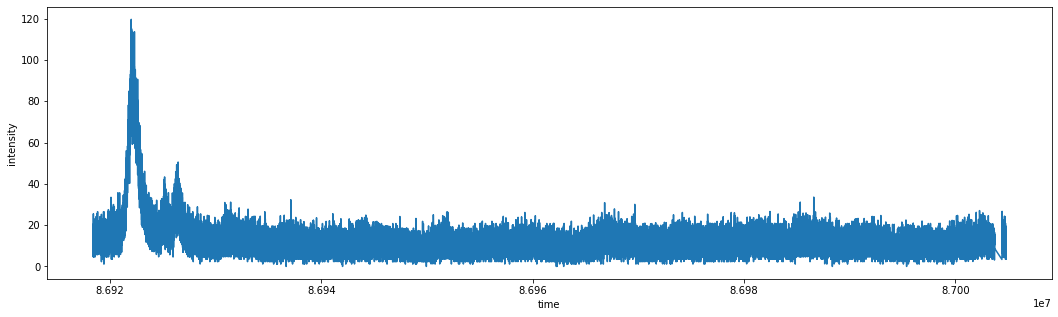

mean 12.473027635305947
std 7.635009545673122
median 10.820351308822634
max 84.19891369628905
increment 73.37856238746642


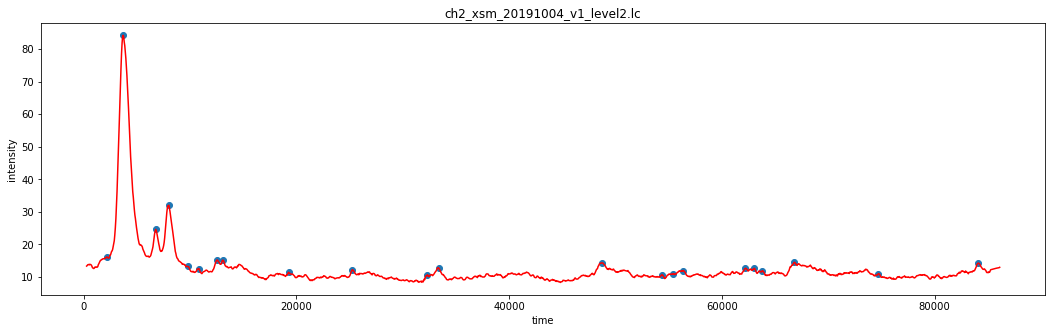

1274.5 13.021317598342897
9913.5 12.74608591556549
2624.5 17.87812557220459
5663.5 17.75300520324707
6263.5 16.385581211090088
8763.5 15.935091020584107
7363.5 17.992590461730956
8613.5 17.864661365509033
9663.5 13.221157180786134
9813.5 13.205313779830934
10713.5 12.472897953033447
10863.5 12.44811582660675
12113.5 11.876363708496093
15463.5 11.80812868785858
12913.5 13.94488119506836
13263.5 13.808744296073913
19113.5 10.487617359161376
19763.5 10.473423301219942
24963.5 10.143183959007263
28063.5 10.034964141845702
32063.5 9.185286907196046
34213.5 9.163390849113465
33113.5 11.76725200366974
33563.5 11.546517729759218
47963.5 10.667645685195922
51463.5 10.6178197183609
54263.5 10.402916893005372
54513.5 10.124162674427033
54713.5 9.74375569820404
58613.5 9.742782018661499
56263.5 11.74429103565216
56463.5 11.670438247680664
61863.5 10.911678957462312
64063.5 10.584292057037354
62913.5 12.348242944717407
63163.5 12.016457547187805
63713.5 11.531501415252686
63963.5 11.337847517013552

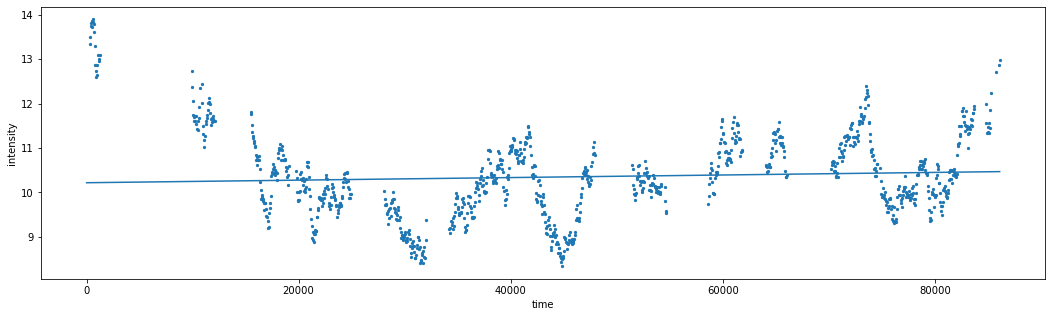

mark:  21530.875
break, array_bg_times etc ready 


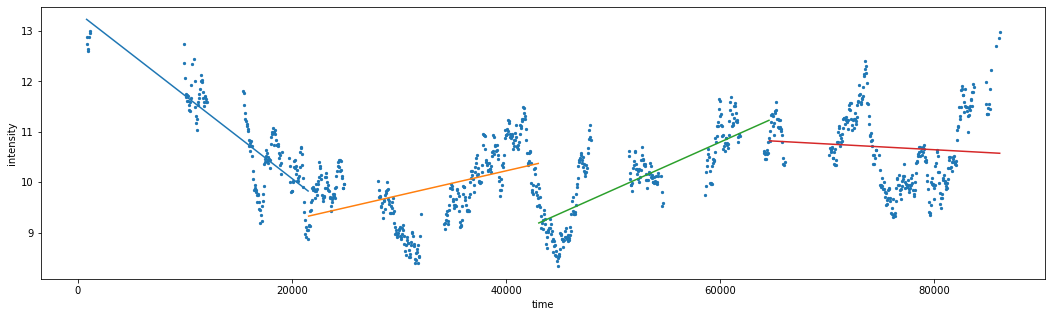

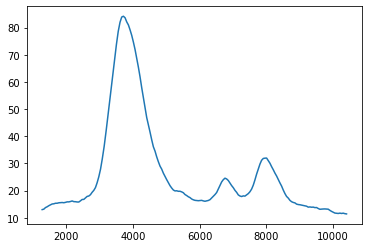

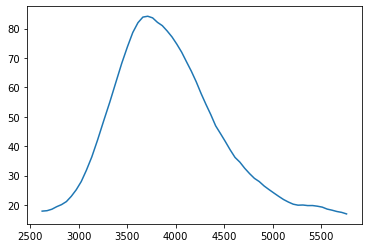

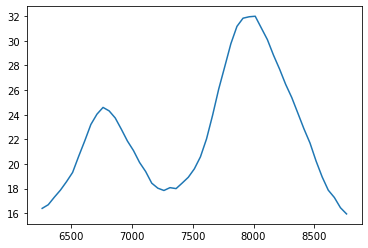

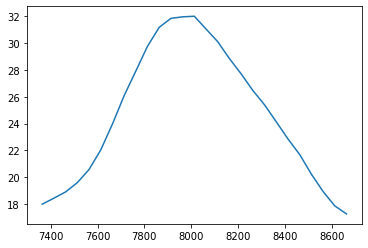

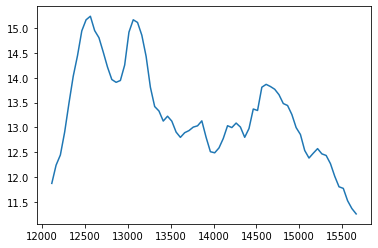

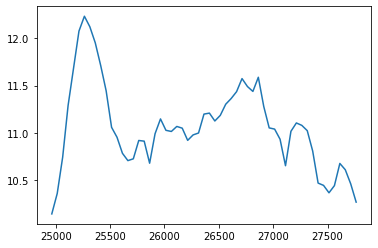

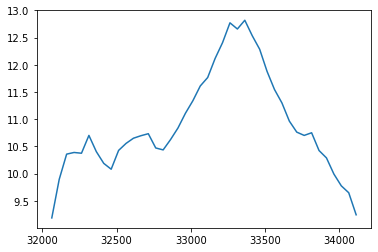

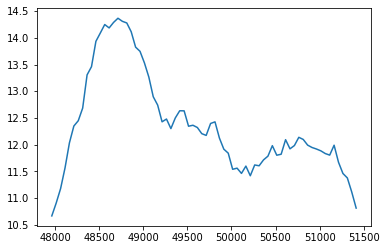

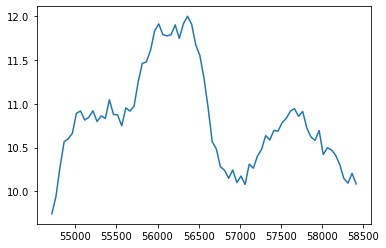

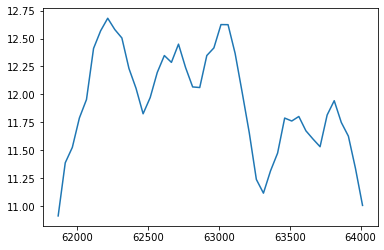

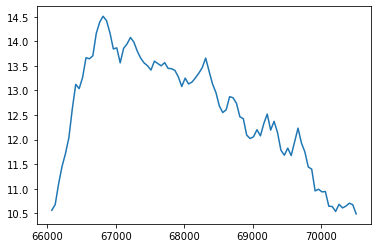

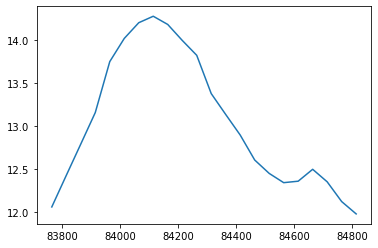

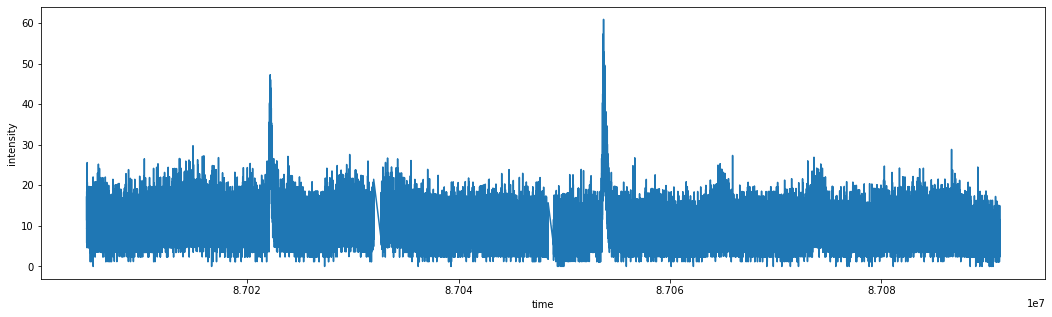

mean 10.17793389530481
std 2.2282379457292754
median 9.707492909431458
max 36.737831832885746
increment 27.030338923454288


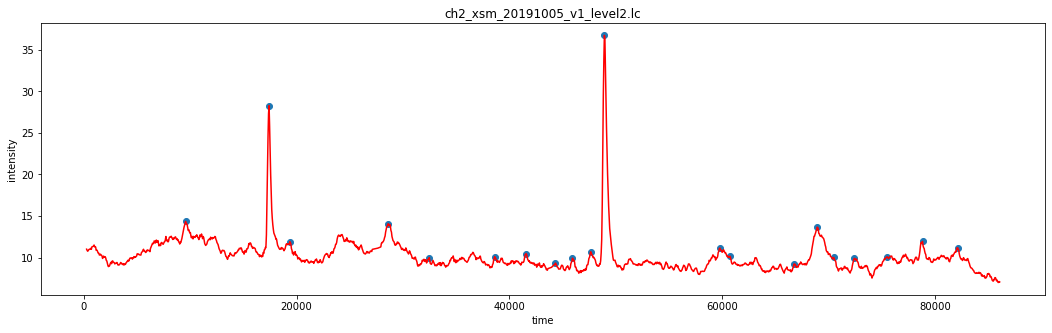

9225.5 12.27599498462677
10275.5 12.24418014240265
17122.5 11.1761650557518
18372.5 11.078750406265259
18972.5 11.28366856098175
19522.5 11.067582153320313
28322.5 12.572165798187257
28972.5 12.52352417564392
32372.5 9.804892435073851
32522.5 9.65019904756546
38374.5 8.837512159824373
42974.5 8.815994593620301
41324.5 9.427448757171632
41924.5 9.39747887802124
43574.5 8.471895444869995
45182.5 8.45968107032776
45632.5 8.55112669992447
46332.5 8.409994644641877
47332.5 9.130144131183625
48232.5 9.032651424407959
48532.5 9.198090390682221
50082.5 9.11234677839279
59582.5 10.167166122436523
60482.5 10.096133327484132
60632.5 10.017848268508912
60782.5 9.97967712402344
66582.5 8.4198644657135
70932.5 8.376090488433839
68282.5 10.016378168582916
70332.5 9.913388256549837
70382.5 9.825445977687837
70532.5 9.81738794708252
72132.5 8.446671144485475
73782.5 8.333415189743043
74182.5 7.8251552653312695
84382.5 7.791750841140747
78432.5 9.687723338127137
79582.5 9.604808572769166
82032.5 10.9700

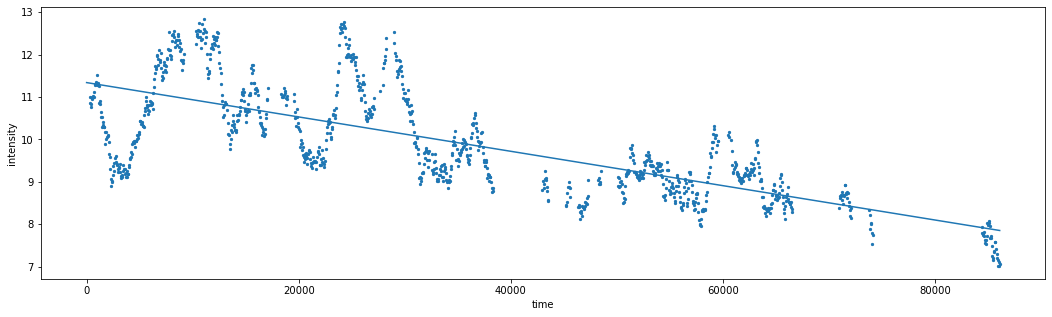

mark:  21523.125
break, array_bg_times etc ready 


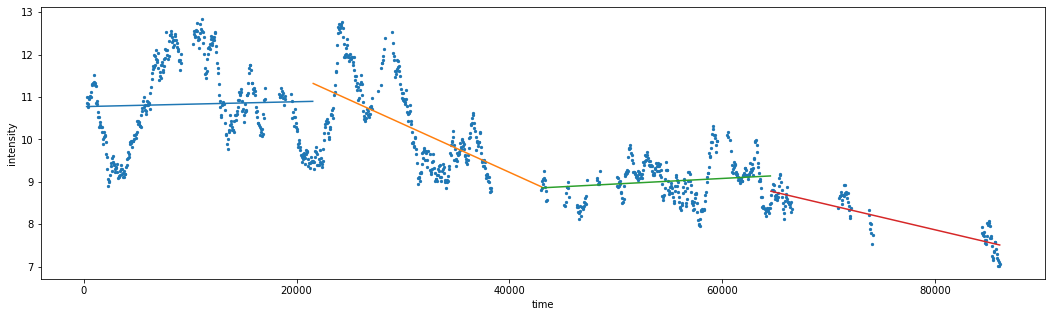

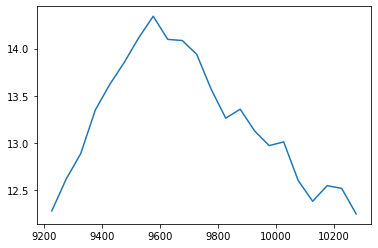

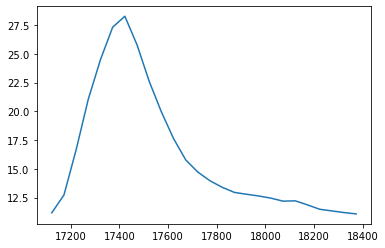

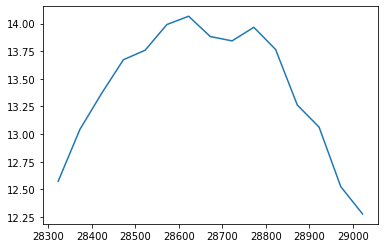

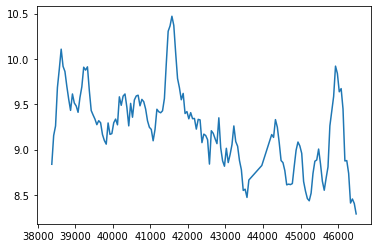

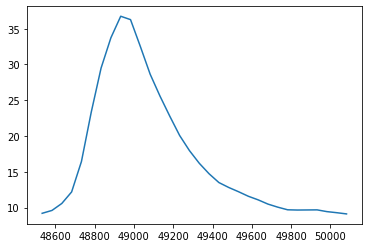

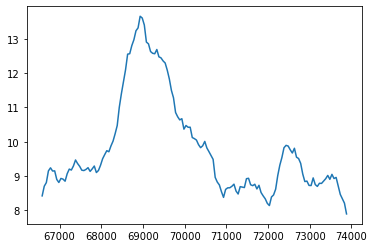

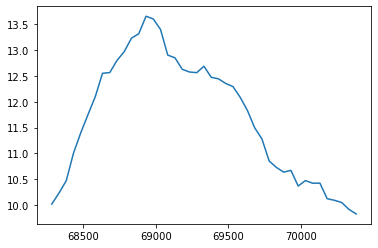

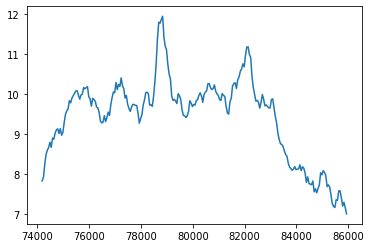

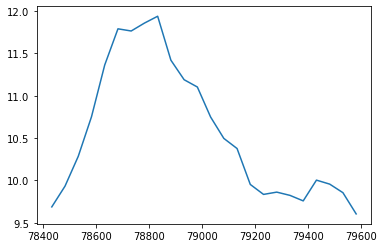

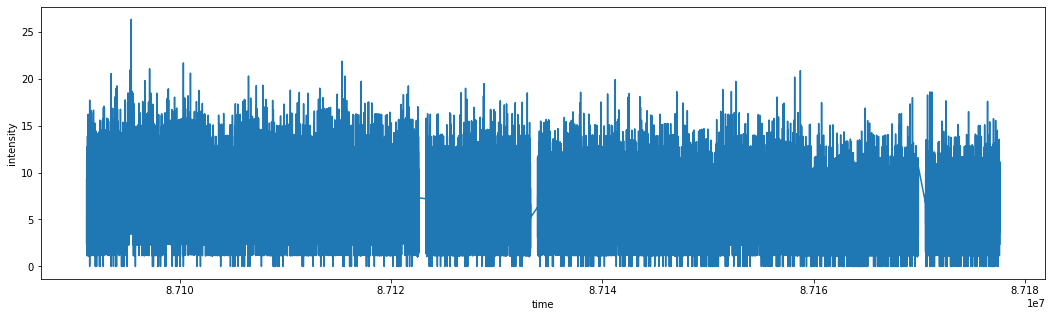

mean 6.59206451670633
std 0.8487467923062246
median 6.562181087732316
max 11.900735434532168
increment 5.338554346799851


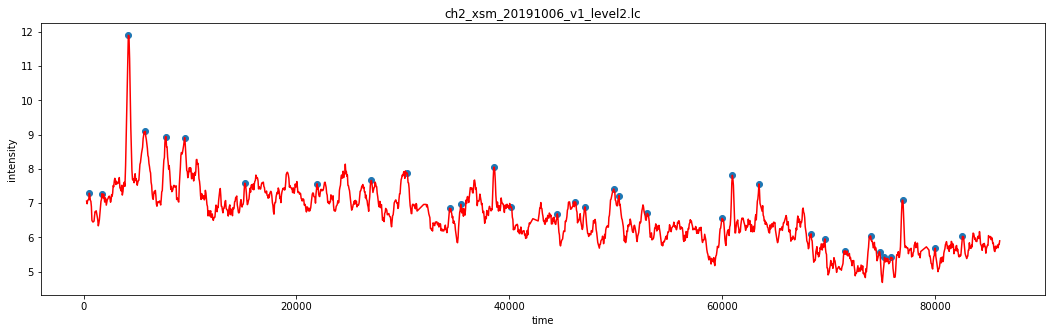

424.5 7.092109967708588
624.5 7.0770010509490975
1474.5 6.514142350196839
12186.5 6.496041134357453
3876.64 7.491603832721712
6436.5 7.278833582401276
5586.5 8.882950024604797
5886.5 8.860903975009919
7286.5 7.105656568050385
8736.5 7.1054597601890555
8936.5 7.030659511566162
11586.5 6.958058850765229
14986.5 6.964577890872954
15386.5 6.955613740921021
21786.5 6.999462693691254
23086.5 6.978447502613069
26786.5 6.760907284259797
28036.5 6.718107026576996
30286.5 7.857474573135376
30436.5 7.844953639984131
34239.5 6.2910598635673525
34939.5 6.215808065891267
35139.5 5.8426507835388195
44765.5 5.80494261264801
38389.5 6.807046998023988
38989.5 6.767278913021089
40089.5 6.875405125617982
40239.5 6.830040745735169
44415.5 6.491601585388183
44615.5 6.364366536617279
46116.5 6.894620611190796
46316.5 6.796413797855378
46916.5 6.29770303440094
47316.5 6.242433502674103
49316.5 6.299661412239075
50766.5 6.11085657787323
50216.5 7.090356820583344
50366.5 6.933075480461121
52866.5 6.498062626361

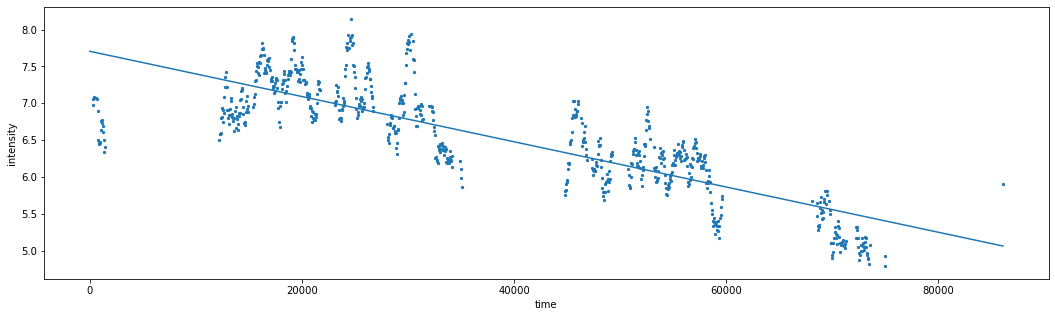

mark:  21526.125
break, array_bg_times etc ready 


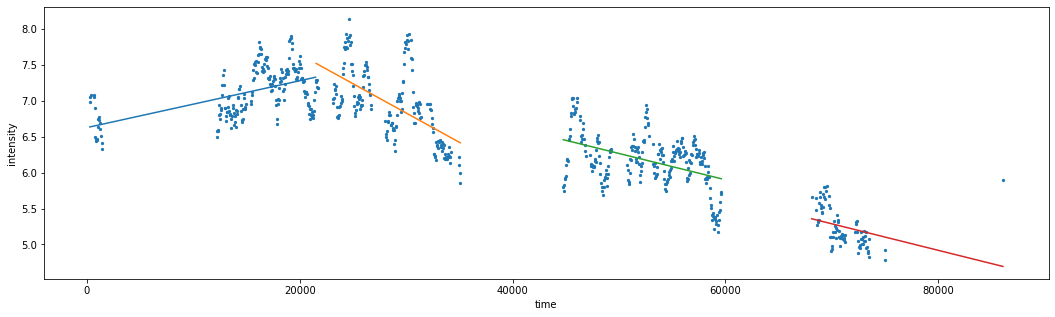

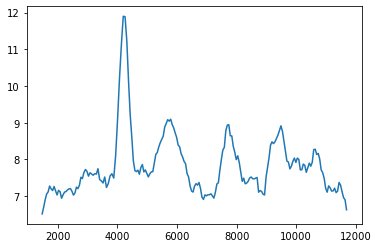

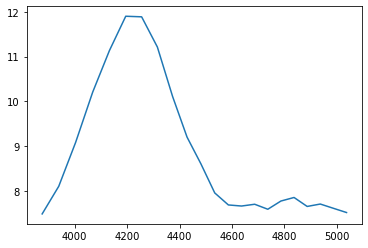

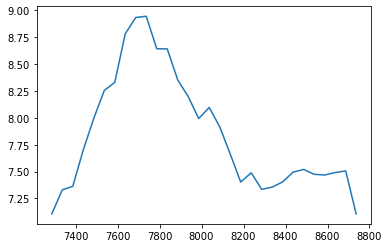

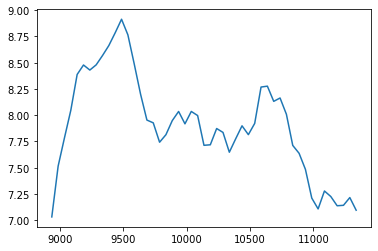

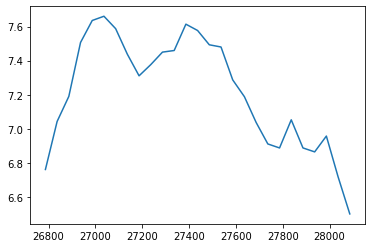

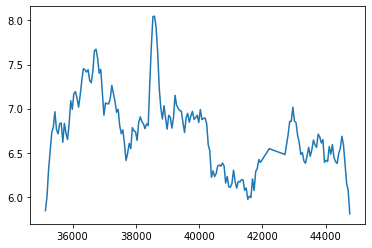

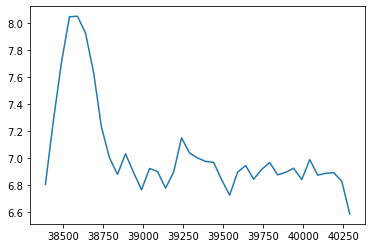

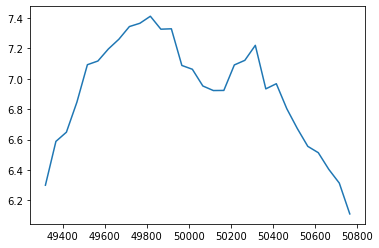

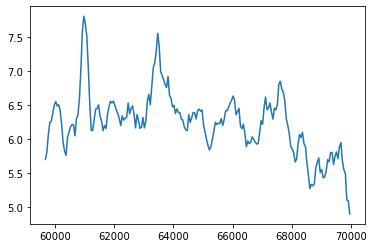

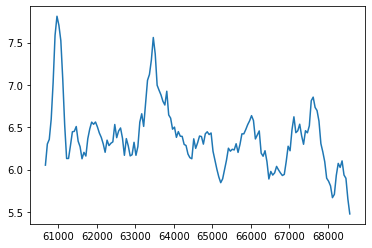

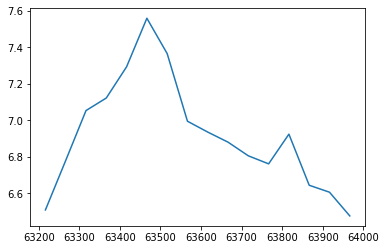

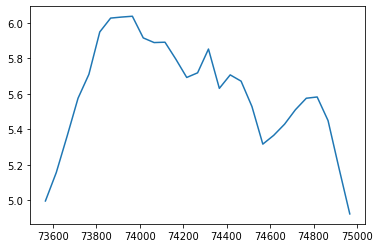

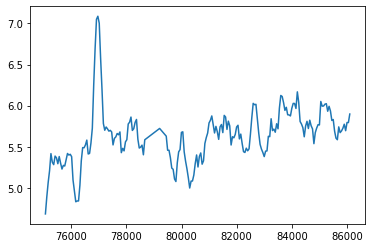

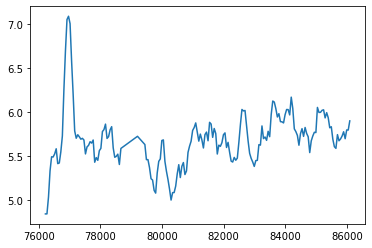

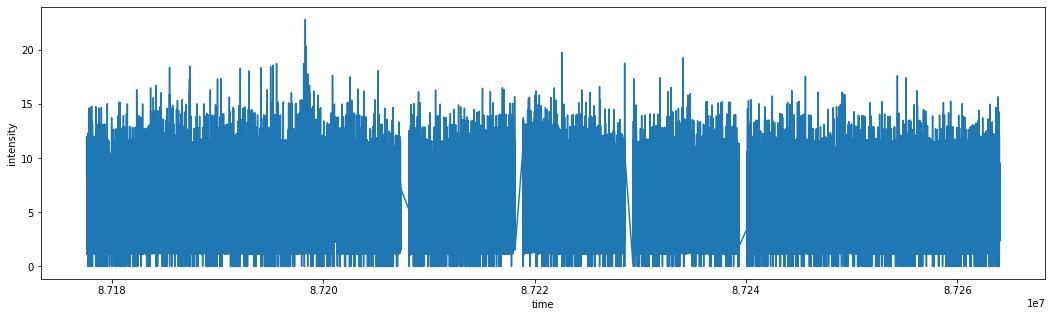

mean 5.805055920125783
std 0.3893666628741191
median 5.771624459266663
max 8.767271349906922
increment 2.995646890640259


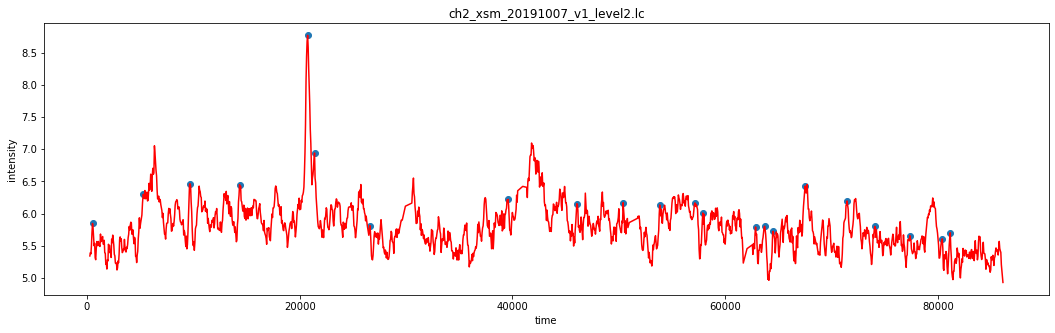

374.5 5.3762276649475105
774.5 5.315675376892091
4774.5 5.4155684390068055
26744.5 5.348025341033936
9394.5 5.454537922382355
10094.5 5.43217550945282
14094.5 5.590068891048432
16894.5 5.5260604429245
20344.5 6.332924094200135
21544.5 6.253293366909028
21294.5 6.704070109367371
21444.5 6.551333700180054
26494.5 5.665772421360016
26694.5 5.561070177078248
39389.5 6.058458292484284
39689.5 5.920275870800019
45846.5 5.545982799530029
49296.5 5.5300664916038516
49896.5 5.885399262905121
50046.5 5.832574329853058
53642.5 5.506960467338562
57542.5 5.445482895851136
57042.5 6.038647265434266
57442.5 5.833805259227753
57742.5 5.508020781517029
61642.5 5.452425281047821
62747.5 5.456733905792237
62997.5 5.43971200990677
63597.5 5.699605242252351
63797.5 5.678543150424957
64297.5 5.147557998657227
80499.5 5.147526467800141
67199.5 5.652326941967011
68349.5 5.530770318508148
70899.5 5.168438385486604
76999.5 5.167876223087311
73749.5 5.212472384929658
76999.5 5.167876223087311
76999.5 5.167876223

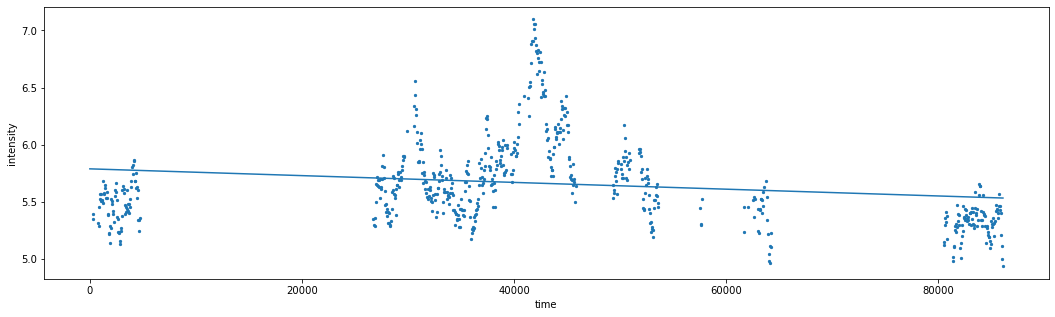

mark:  21527.375
break, array_bg_times etc ready 


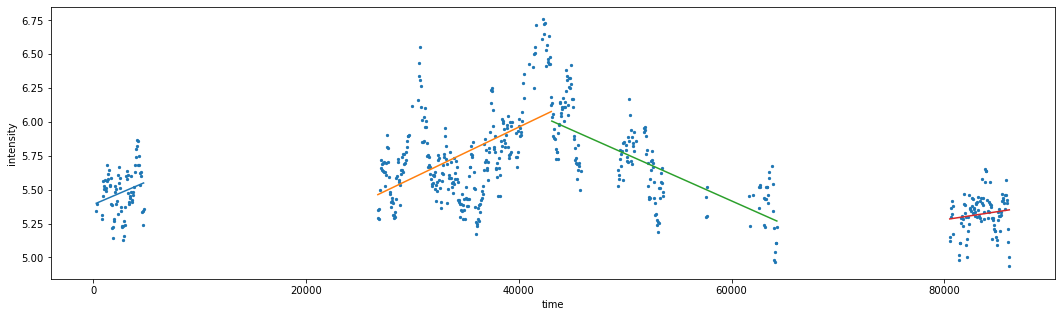

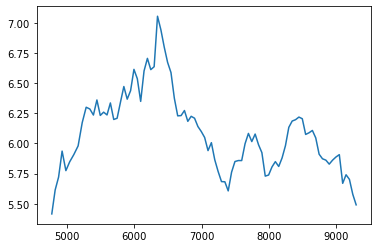

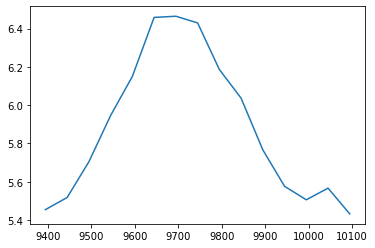

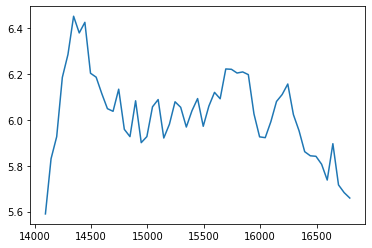

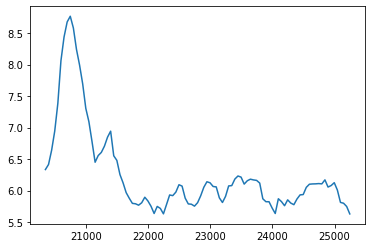

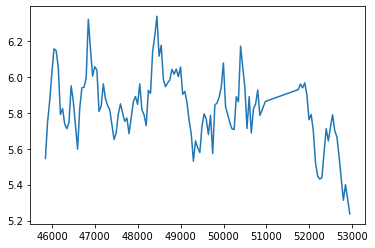

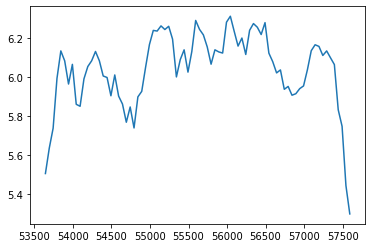

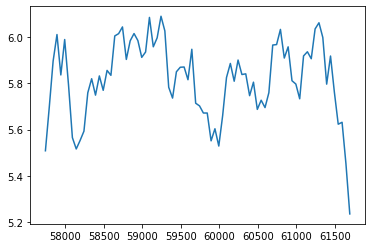

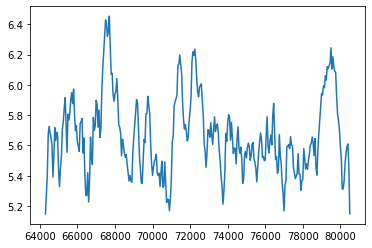

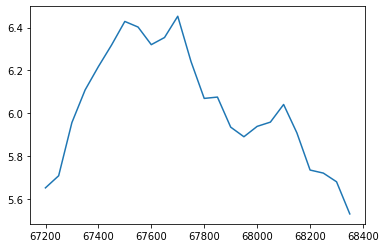

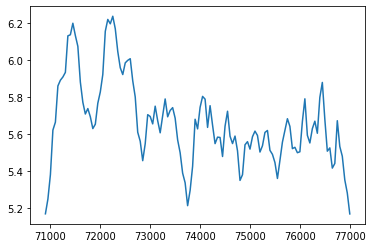

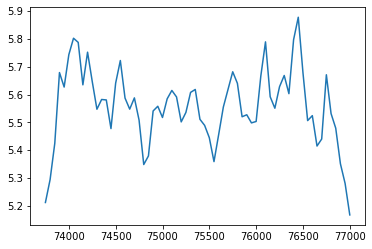

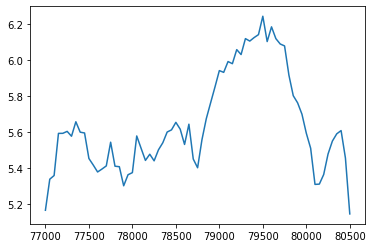

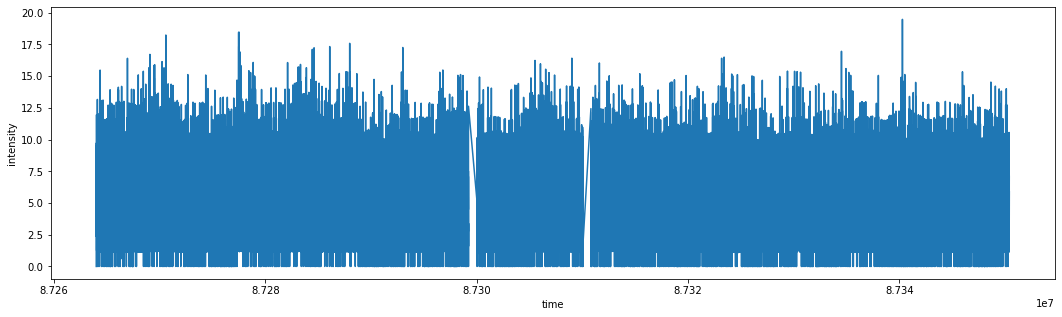

mean 5.210282323182726
std 0.48621526101718743
median 5.119911201953888
max 8.024568616390228
increment 2.9046574144363397


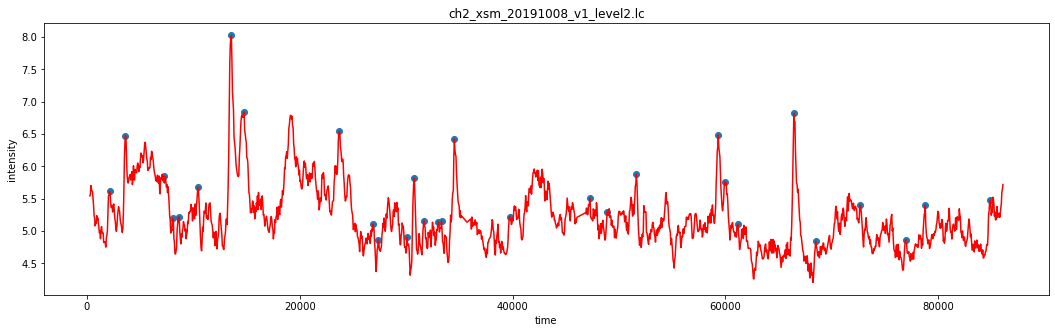

1824.5 4.8909628190994265
8173.5 4.88667970609665
3323.5 4.978090833663941
7873.5 4.970727151393891
7123.5 5.779806088924409
7273.5 5.742623468875885
7973.5 5.004003926277162
8173.5 4.88667970609665
8373.5 4.688867338180542
25626.5 4.683697756290436
10323.5 5.445312457561493
10573.5 5.325029236793519
13173.5 5.100557937145233
16724.5 5.077481997013092
14273.5 5.8578128852844245
15173.5 5.810451084136963
23176.5 5.469377967357636
24276.5 5.465122232913972
26326.5 4.801623947620392
27076.5 4.718255928993226
27176.5 4.374950468063354
30377.5 4.3188654656410215
29977.5 4.660398556232452
30327.5 4.499949801445007
30427.5 4.399567378044129
62583.5 4.365780885696411
31477.5 4.634787479877472
33877.5 4.61057656288147
32327.5 4.755549083709717
33527.5 4.702535061836243
32927.5 5.013973302841187
33127.5 4.986664103984834
33977.5 4.522856127738953
55133.5 4.518058016300202
39480.5 4.694094515800476
55083.5 4.548154054641724
47183.5 5.392313296318055
47333.5 5.232832637310028
48733.5 4.88825701856

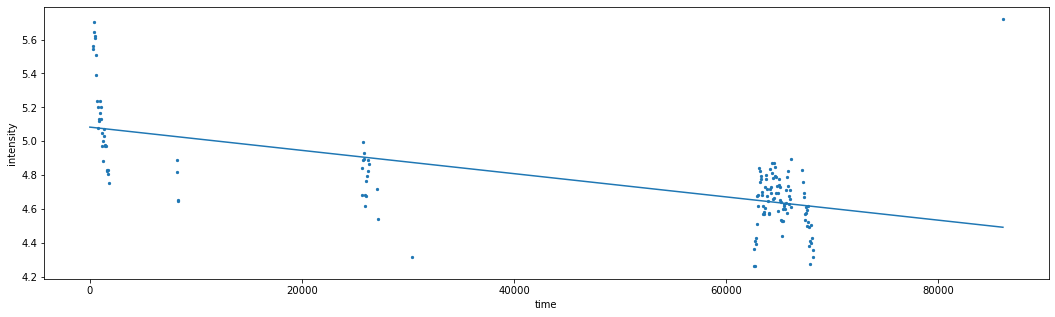

mark:  21523.375
break, array_bg_times etc ready 


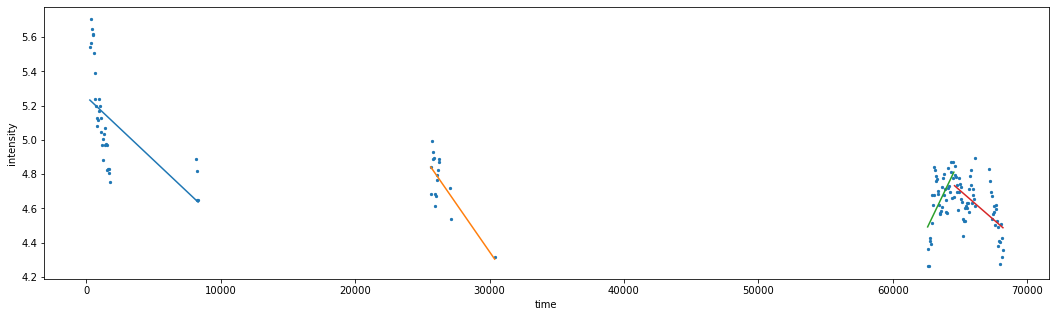

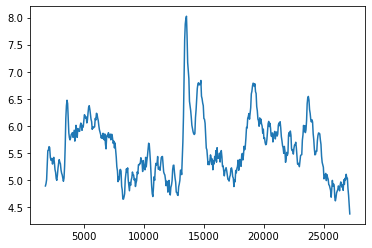

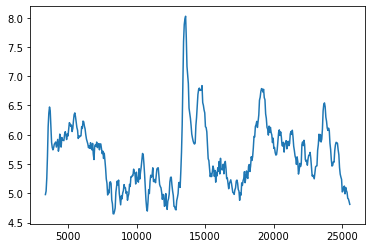

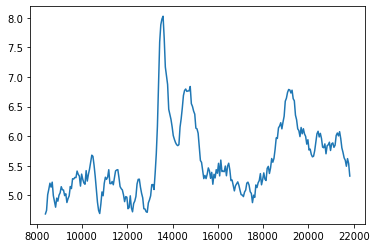

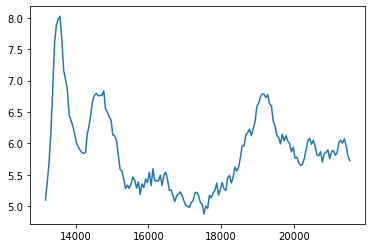

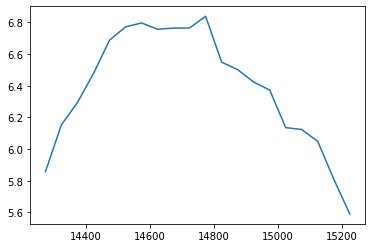

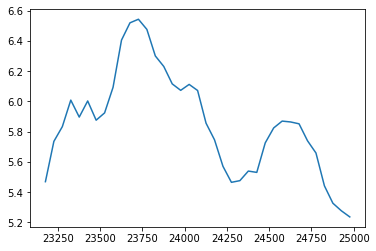

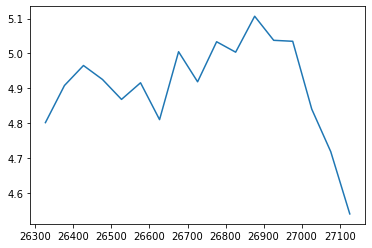

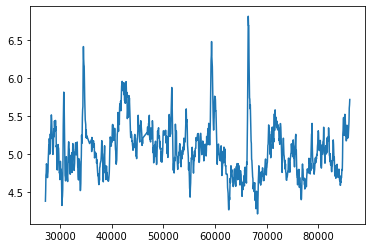

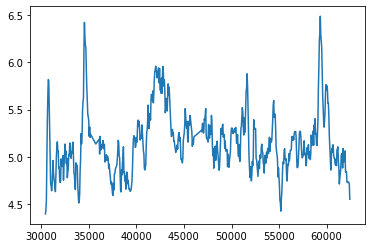

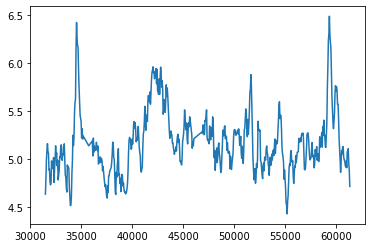

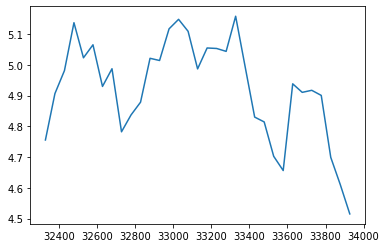

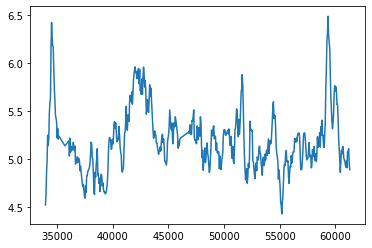

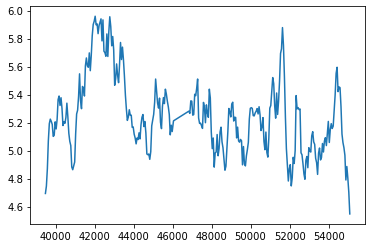

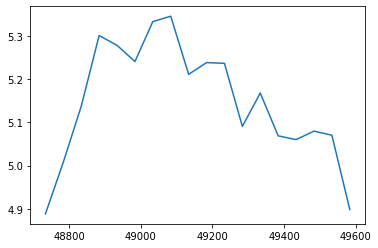

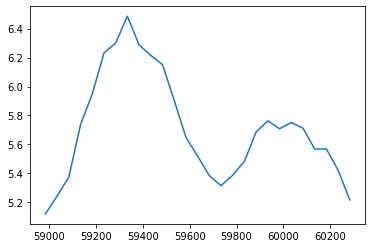

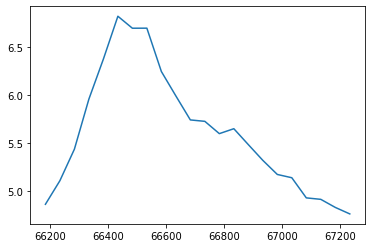

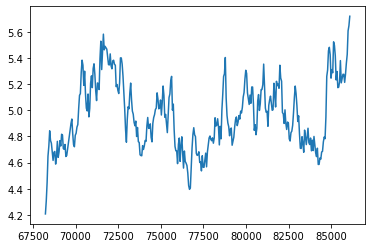

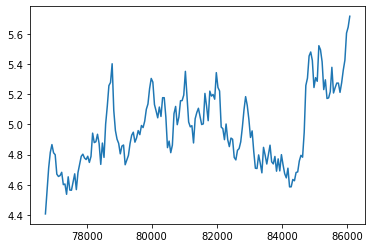

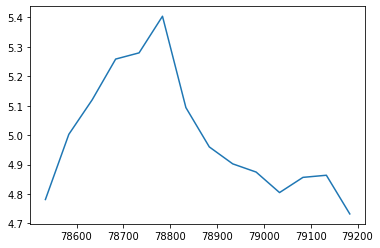

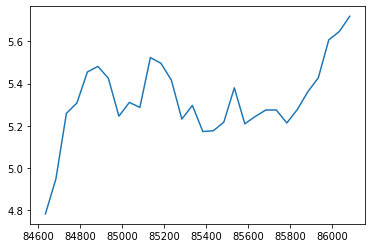

In [32]:
%matplotlib inline



def biquad(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

for i in range(4,9):
    s = 'ch2_xsm_2019100' + str(i) + '_v1_level2.lc'
    
    dat = prepare_data(s)
    fl_marks, time, intensity = display_data(dat)#preliminary flare_marks are returned
    data_len = len(time)
    #fl_marks_broken = split_flare_marks(n,fl_marks,time[-1])
    #print(fl_marks_broken)
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    i_new,t_new = remove_flares2(fl_marks, time, intensity) #flareless backround returned
    
                #added initial and final values incase the fit gets drastically wrong - required for some binning values on some days
    
    #i_new.insert(0,intensity[0])
    #t_new.insert(0,time[0])
    #i_new = shrink_std(i_new)
    popt, pcov = curve_fit(line, t_new, i_new) #fit linear background

    m = popt[0]
    c = popt[1]
    plt.scatter(t_new, i_new,s=5)
    arr = np.linspace(0,time[-1],200)
    y1 = []
    for i in arr:
        y1.append(line(i,m,c))

    plt.plot(arr,y1)
    plt.show()
    
    plt.figure(figsize = (18,5))
    plt.xlabel('time')
    plt.ylabel('intensity')
    t_new, i_new = remove_outliers(t_new, i_new, m, c)#remove outliers
    plt.scatter(t_new, i_new,s=5)
    

    #now we will break the data into parts and fit lines to each part
    n_parts = 4
    mark = (time[-1]+10)/n_parts
    print('mark: ', mark)
    arr_bg_times = []
    arr_bg_intensities = []
    for i in range(n_parts):
        arr_t = []
        arr_i = []
        for j in range(len(t_new)):
            if mark*i < t_new[j] < mark*(i+1):
                arr_t.append(t_new[j])
                arr_i.append(i_new[j])
        arr_bg_times.append(arr_t)
        arr_bg_intensities.append(arr_i)
   # print(arr_bg_times)
    #print(arr_bg_intensities)
    
    print('break, array_bg_times etc ready ')
    
    m_arr = []
    c_arr = []
    
    for i in range(len(arr_bg_times)):
        popt,pcov = curve_fit(line, arr_bg_times[i], arr_bg_intensities[i])
        m = popt[0]
        c = popt[1]
        #plt.plot(arr_bg_times[i], arr_bg_intensities[i])
        #print(arr_bg_times[i])
        arr = np.linspace(arr_bg_times[i][0],arr_bg_times[i][-1],200)
        y1 = []
        
        for i in arr:
            y1.append(line(i,m,c))
       # print(arr)
        plt.plot(arr,y1)
        m_arr.append(m)
        c_arr.append(c)
    plt.show()

    flare_starts = np.zeros(len(fl_marks))
    for i in range(len(fl_marks)):
        flare_starts[i] = fl_marks[i][0]

    #print(flare_starts)
    std_bg = np.std(i_new)

    flares_t = []
    flares_i = []
    for i in range(0,len(time)):
        if time[i] in flare_starts:
            l_t = []
            l_i = []
            #start = time[i]
            started = True
            for j in range(len(time)-i):
                l_t.append(time[i+j])
                l_i.append(intensity[i+j])
                if intensity[i+j] -  intensity[i] < broken_lines(time[i+j],mark,m_arr,c_arr) - broken_lines(time[i],mark,m_arr,c_arr):
                    started = False
                    if len(l_t) > 10 and max(l_i) - min(l_i) > 1.4*std_bg :
                        flares_t.append(l_t)
                        flares_i.append(l_i)
                    break
            if started:
                started = False
                if len(l_t) > 10 and max(l_i) - min(l_i) > 1.4*std_bg :
                    flares_t.append(l_t)
                    flares_i.append(l_i)
    
    
    for i in range(len(flares_t)):
        #print(np.std(flares_i[i]))
        '''popt,pcov = curve_fit(convolution_flare, flares_t[i], flares_i[i],(max(flares_i[i])/10, flares_t[i][np.argmax(np.array(flares_i[i]))],10,0.01,np.mean(i_new)/10))
        a = popt[0]
        b = popt[1]
        c = popt[2]
        d = popt[3]
        e = popt[4]
        print(popt)
        #d = popt[3]
        #print(pcov)'''
        plt.plot(flares_t[i], flares_i[i])
        
        '''arr = np.linspace(flares_t[i][0],flares_t[i][-1],20)
        y1 = []
        for i in arr:
            y1.append(convolution_flare(i,a,b,c,d,e))
        plt.plot(arr,y1)'''
        plt.show()
    #print(i_new)